In [1]:
import numpy as np
import pandas as pd
import torch
import os
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import urllib.request
import seaborn as sns

np.random.seed(13)

pd.set_option('display.max_columns', None)

# DATA ACQUISITION

In [2]:
datasets_csv = ["movies.csv", "ratings.csv", "genome-scores.csv", "genome-tags.csv", "links.csv", "tags.csv"]
datasets_name = [i[:-4].replace("-", "_") for i in datasets_csv]

root_URL = "http://github.com/MickPerl/DataAnalyticsProject/releases/download/datasets/"
remote_url = ["".join([root_URL, i]) for i in datasets_csv]

In [3]:
try :
    if os.getcwd().split("\\")[-1] != 'ml-25m':
        os.chdir('data\ml-25m')
except FileNotFoundError :
    os.makedirs("data\ml-25m")
    os.chdir('data\ml-25m')

In [4]:
# per vedere se i csv sono già presenti
!ls

# per assicurarsi di essere nel virtual environment
!which python

df-per-fillna.csv
genome-scores.csv
genome-tags.csv
links.csv
movies.csv
ratings.csv
tags.csv
/c/Users/miche/Documents/GitHub/DataAnalyticsProject/venv/Scripts/python


In [5]:
!pwd

/c/Users/miche/Documents/GitHub/DataAnalyticsProject/data/ml-25m


In [6]:
for i in range(len(datasets_csv)):
    try :
        globals()["_".join(['df', datasets_name[i]])] = pd.read_csv(datasets_csv[i])
    except FileNotFoundError:
        print(f"Download in progress of {datasets_csv[i]}")
        file = urllib.request.urlretrieve(remote_url[i], datasets_csv[i])
        globals()["_".join(['df', datasets_name[i]])] = pd.read_csv(file[0])

# PRE PROCESSING

In [7]:
df_movies["year"] = [i.strip()[-5:-1] for i in df_movies["title"]]
df_movies["title_length"] = [len(i) for i in df_movies["title"]]
df_movies.drop("title", inplace=True, axis=1)

In [8]:
# SPIEGARE
mlb = MultiLabelBinarizer()
df_movies = df_movies.join(pd.DataFrame(
                mlb.fit_transform(df_movies.pop('genres').str.split('|')),
                index=df_movies.index,
                columns=mlb.classes_))

In [9]:
df_movies['genres'] = df_movies.iloc[:,3:23].values.tolist()

Hamming

In [50]:
# np.sum(np.bitwise_xor([1,1,0,0,0],[1,0,1,1,0]))

In [10]:
df_genome = pd.merge(df_genome_tags, df_genome_scores, on="tagId", how="right")

In [11]:
df_genome = df_genome.pivot(index='movieId', columns='tag', values="relevance")
df = pd.merge(df_movies, df_genome, on="movieId", how = "left")

In [12]:
df_ratings = df_ratings.iloc[:,[1,2]]
df_ratings = df_ratings.groupby(by='movieId').mean()


In [13]:
df = pd.merge(df_ratings, df, on="movieId", how="right")

In [14]:
df_X = df.loc[:,df.columns != 'rating']
df_Y = df['rating']

X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=20)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=20)

In [ ]:
pd.set_option('display.max_rows', df.shape[0]+1)
# df.describe()

Select rows with missing data

In [ ]:
# df.fillna(0)

In [15]:
df.to_csv("df_per_fillna.csv", index=False)

In [100]:
!ls

df-per-fillna.csv
genome-scores.csv
genome-tags.csv
links.csv
movies.csv
ratings.csv
tags.csv


In [17]:
pd.read_csv("df_per_fillna.csv")

c:\Users\miche\Documents\GitHub\DataAnalyticsProject\venv\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


movieId    rating  year  title_length  (no genres listed)  Action  \
0            1  3.893708  1995            16                   0       0   
1            2  3.251527  1995            14                   0       0   
2            3  3.142028  1995            23                   0       0   
3            4  2.853547  1995            24                   0       0   
4            5  3.058434  1995            34                   0       0   
...        ...       ...   ...           ...                 ...     ...   
62418   209157  1.500000  2018             9                   0       0   
62419   209159  3.000000  2001            25                   0       0   
62420   209163  4.500000  2018            16                   0       0   
62421   209169  3.000000  2001            19                   1       0   
62422   209171  3.000000  1962            30                   0       1   

       Adventure  Animation  Children  Comedy  Crime  Documentary  Drama  \
0              1          1         1       1      0            0      0   
1              1          0         1       0      0            0      0   
2              0          0         0       1      0            0      0   
3              0          0         0       1      0            0      1   
4              0          0         0       1      0            0      0   
...          ...        ...       ...     ...    ...          ...    ...   
62418          0          0         0       0      0            0      1   
62419          0          0         0       0      0            1      0   
62420          0          0         0       1      0            0      1   
62421          0          0         0       0      0            0      0   
62422          1          0         0       0      0            0      1   

       Fantasy  Film-Noir  Horror  IMAX  Musical  Mystery  Romance  Sci-Fi  \
0            1          0       0     0        0        0        0       0   
1            1          0       0     0        0        0        0       0   
2            0          0       0     0        0        0        1       0   
3            0          0       0     0        0        0        1       0   
4            0          0       0     0        0        0        0       0   
...        ...        ...     ...   ...      ...      ...      ...     ...   
62418        0          0       0     0        0        0        0       0   
62419        0          0       0     0        0        0        0       0   
62420        0          0       0     0        0        0        0       0   
62421        0          0       0     0        0        0        0       0   
62422        0          0       0     0        0        0        0       0   

       Thriller  War  Western  \
0             0    0        0   
1             0    0        0   
2             0    0        0   
3             0    0        0   
4             0    0        0   
...         ...  ...      ...   
62418         0    0        0   
62419         0    0        0   
62420         0    0        0   
62421         0    0        0   
62422         0    0        0   

                                                  genres      007  \
0      [0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...  0.02875   
1      [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...  0.04125   
2      [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  0.04675   
3      [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...  0.03425   
4      [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  0.04300   
...                                                  ...      ...   
62418  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...      NaN   
62419  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...      NaN   
62420  [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...      NaN   
62421  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      NaN   
62422  [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...      NaN   

       007 (series

In [18]:
os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
# os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask

import ray
import modin.pandas as pd_mod
df_temp = pd_mod.read_csv("tags.csv")

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()



FileNotFoundError: [WinError 2] Impossibile trovare il file specificato

In [ ]:
df_temp = df.fillna(value=0)

In [ ]:
df.to_csv("")

In [ ]:
len(df[pd.isnull(df).any(axis=1)])


In [17]:
len(df[pd.isnull(df).any(axis=1)])

45231

## Checking duplicates 

In [16]:
any(df.astype(str).duplicated())

False

## Evaluating standardization

Si è valutata fattibilità della standardizzazione sulle relevance dei tags, ma non ha distribuzione gaussiana.

In [17]:
X_train_tags = X_train.iloc[:, 24:]
# X_train_tags_mean = X_train_tags.mean()
# X_train_tags_std = X_train_tags.std()
# X_train.iloc[:, 24:] = (X_train_tags - X_train_tags_mean) / X_train_tags_std
# X_val.iloc[:, 24:] = (X_val.iloc[:, 24:] - X_train_tags_mean) / X_train_tags_std
# X_train.iloc[:, 24:] = (X_test.iloc[:, 24:] - X_train_tags_mean) / X_train_tags_std

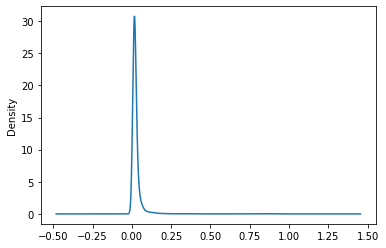

In [18]:
X_train_tags.loc[:, "american civil war"].plot(kind ='density')
plt.show()

In [19]:
pd.set_option('expand_frame_repr', False)
list(df.columns)

['movieId',
 'rating',
 'year',
 'title_length',
 '(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western',
 'genres',
 '007',
 '007 (series)',
 '18th century',
 '1920s',
 '1930s',
 '1950s',
 '1960s',
 '1970s',
 '1980s',
 '19th century',
 '3d',
 '70mm',
 '80s',
 '9/11',
 'aardman',
 'aardman studios',
 'abortion',
 'absurd',
 'action',
 'action packed',
 'adaptation',
 'adapted from:book',
 'adapted from:comic',
 'adapted from:game',
 'addiction',
 'adolescence',
 'adoption',
 'adultery',
 'adventure',
 'affectionate',
 'afi 100',
 'afi 100 (laughs)',
 'afi 100 (movie quotes)',
 'africa',
 'afterlife',
 'aging',
 'aids',
 'airplane',
 'airport',
 'alaska',
 'alcatraz',
 'alcoholism',
 'alien',
 'alien invasion',
 'aliens',
 'allegory',
 'almodovar',
 'alone in the world',
 'alter ego',
 'alternate en

## Evaluating normalization

In [53]:
any(Y_train < 1)

False

## Evaluating labels' unbalance

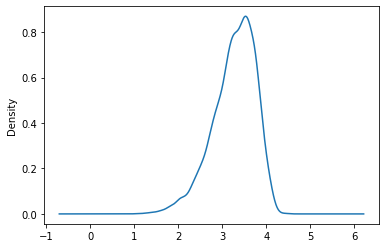

In [20]:
Y_train.plot(kind ='density')
plt.show()

In [54]:
len(Y_train)

9946

In [48]:
cat = []

for i in range(0.5, 4.5,  0.5) :
    cat.append(Y_train.loc[Y_train >= i & Y_train < i+0.5])

max(len(cat))

12716    4.027100
1076     4.014332
3976     4.033846
5987     4.082880
12531    4.080328
1094     4.035884
1099     4.048278
12876    4.082083
6581     4.053627
12916    4.069954
13249    4.200000
2660     4.228311
7302     4.006849
7346     4.066310
12701    4.151786
1701     4.077006
10638    4.015198
1108     4.127091
2551     4.045397
3137     4.021732
2566     4.107340
11139    4.078100
3885     4.032448
106      4.002273
11882    4.074405
684      4.215804
775      4.324336
821      4.206564
1093     4.142050
12261    4.028889
1073     4.144122
12382    4.038306
10945    4.068675
2612     4.104965
986      4.092294
13178    4.111212
2783     4.053081
12678    4.122302
4758     4.126880
680      4.104362
12476    4.078947
7958     4.052304
7999     4.040541
13794    4.209677
856      4.022018
13156    4.005814
12444    4.056122
807      4.137713
1022     4.065127
12360    4.033416
3342     4.043699
662      4.103381
11681    4.097928
6313     4.010880
11972    4.105127
1177     4

## Checking correlation

In [ ]:
sns.set_theme(style="ticks")
sns.pairplot(df, hue="species")

In [ ]:
# PRE DATA VISUALIZATION
df_Y.plot(kind ='density')
plt.show()

[] Normalizzazione (valtare se serve stampando distanze tra campioni)\
[] SVM regressione e custom kernel